In [1]:
import torch 
import torch.nn as nn
import numpy as np 
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset,DataLoader
import pandas as pd


In [10]:
class TestingNet(nn.Module):
    def __init__(self,sizes):
        super().__init__()
        self.sizes=sizes
        self.ll1=nn.Linear(sizes[0],sizes[1],bias=True)
        self.act=nn.modules.activation.Sigmoid()
        self.ll2=nn.Linear(sizes[1],sizes[2],bias=True)
        #self.ll3=nn.Linear(sizes[2],sizes[3],bias=True)
    def forward(self,X):
        z1=self.ll1(X)
        a1=self.act(z1)
        z2=self.ll2(a1)
        a2=self.act(z2)
        #z3=self.ll3(a2)
        #a3=self.act(z3)
        return a2
    

In [3]:
#Defining the baseline regressor:
class BaselineRegressor:
    """
    Baseline regressor, which calculates the mean value of the target from the training
    data and returns it for each testing sample.
    """
    def __init__(self):
        self.mean = 0

    def fit(self, X_train: np.ndarray, y_train: np.ndarray):
        self.mean = np.mean(y_train, axis=0)
        self.classes_count = y_train.shape[1]  #len=4
        return self

    def predict(self, X_test: np.ndarray):
        return np.full((len(X_test), self.classes_count), self.mean)

In [4]:
#Loading in the data set:
class SpectralCurveFiltering():
    """
    Create a histogram (a spectral curve) of a 3D cube, using the merge_function
    to aggregate all pixels within one band. The return array will have
    the shape of [CHANNELS_COUNT]
    """

    def __init__(self, merge_function = np.mean):
        self.merge_function = merge_function

    def __call__(self, sample: np.ndarray):
        return self.merge_function(sample, axis=(1, 2))

In [5]:
import os
from glob import glob

def load_data(directory: str):
    """Load each cube, reduce its dimensionality and append to array.

    Args:
        directory (str): Directory to either train or test set
    Returns:
        [type]: A list with spectral curve for each sample.
    """
    data = []
    filtering = SpectralCurveFiltering()
    all_files = np.array(
        sorted(
            glob(os.path.join(directory, "*.npz")),
            key=lambda x: int(os.path.basename(x).replace(".npz", "")),
        )
    )
    for file_name in all_files:
        with np.load(file_name) as npz:
            arr = np.ma.MaskedArray(**npz)
        arr = filtering(arr)
        data.append(arr/1000)
    return np.array(data)


def load_gt(file_path: str):
    """Load labels for train set from the ground truth file.
    Args:
        file_path (str): Path to the ground truth .csv file.
    Returns:
        [type]: 2D numpy array with soil properties levels
    """
    gt_file = pd.read_csv(file_path)
    labels = gt_file[["P", "K", "Mg", "pH"]].values
    return labels


X_train = load_data("train_data")
y_train = load_gt("train_gt.csv")
#X_test = load_data("test_data")
#print(X_train)
#print(y_train)
print(f"Train data shape: {X_train.shape}")
#print(f"Test data shape: {X_test.shape}")


Train data shape: (1732, 150)


In [6]:
#Generating the baseline predictions:
#First we randomly shuffle the data:
Data=np.array(list(zip(X_train,y_train)),dtype=object)
np.random.shuffle(Data)
X_train_new=np.array([(x-x.mean())/np.sqrt(x.var()) for x in Data[:1500,0]])
y_train_new=np.array([y for y in Data[:1500,1]])
X_test_new=np.array([(x-x.mean())/np.sqrt(x.var()) for x in Data[1500:,0]])
y_test_new=np.array([y for y in Data[1500:,1]])
y_test_new_copy=np.copy(y_test_new)
baseline_reg=BaselineRegressor()
# Fit the baseline regressor once again on new training set
baseline_reg = baseline_reg.fit(X_train_new, y_train_new)
baseline_predictions = baseline_reg.predict(X_test_new)

# Generate baseline values to be used in score computation
baselines = np.mean((y_test_new_copy - baseline_predictions) ** 2, axis=0)
max_arr = y_train_new.max(axis=0)
y_train_new_for_NN = y_train_new/max_arr

In [7]:
baselines

array([7.58843355e+02, 3.54317255e+03, 1.54454855e+03, 6.77003935e-02])

In [8]:
temp = y_test_new / max_arr 
y_test_for_graphing = torch.from_numpy(temp.astype(np.float32))

In [11]:
#training the network:
test=TestingNet([150,100,4])
loss=nn.BCELoss()
num_epochs=100
mini_batch_size=50
dataset=TensorDataset(torch.from_numpy(X_train_new.astype(np.float32)),torch.from_numpy(y_train_new_for_NN.astype(np.float32)))
L_vec=[]
L2_vec=[]
x_train_for_graphing = torch.from_numpy(X_train_new.astype(np.float32))
y_train_for_graphing = torch.from_numpy(y_train_new_for_NN.astype(np.float32))
x_test_for_graphing = torch.from_numpy(X_test_new.astype(np.float32))
for epoch in range(num_epochs):
    mini_batches=DataLoader(dataset=dataset,batch_size=mini_batch_size,shuffle=True)
    optimizer=torch.optim.SGD(params=test.parameters(),lr=0.1*(1.01 - epoch/num_epochs),weight_decay=0.01)
    for mini_batch_in,mini_batch_out in mini_batches:
        outs=test.forward(mini_batch_in)
        l=loss(outs,mini_batch_out)
        l.backward()
        optimizer.step()
    with torch.no_grad():
        Outs1=test(x_train_for_graphing)
        Outs2=test(x_test_for_graphing)
        Loss1=loss(Outs1,y_train_for_graphing)
        Loss2=loss(Outs2,y_test_for_graphing)
        L_vec.append(Loss1)
        L2_vec.append(Loss2)
    optimizer.zero_grad()

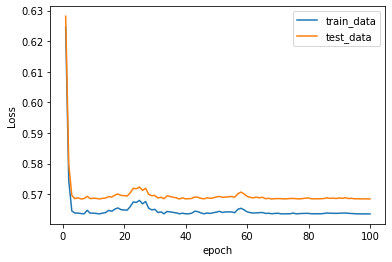

In [12]:
plt.plot(range(1,num_epochs+1),L_vec,label='train_data')
plt.plot(range(1,num_epochs+1),L2_vec,label='test_data')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
#Predictions of the network:
X_test_tensor=torch.from_numpy(X_test_new.astype(np.float32))
with torch.no_grad():
    predictions_tensor=test(X_test_tensor)
predictions=predictions_tensor.numpy()

predictions = predictions*max_arr

mse=np.mean((predictions-y_test_new_copy)**2,axis=0)

scores=mse/baselines

final_score = np.mean(scores)

for score, class_name in zip(scores, ["P", "K", "Mg", "pH"]):
    print(f"Class {class_name} score: {score}")

print(f"Final score: {final_score}")

Class P score: 1.0015347835407715
Class K score: 1.0009544558327708
Class Mg score: 0.9992082068775733
Class pH score: 0.9962215505152324
Final score: 0.9994797491915869


In [14]:
predictions

array([[ 69.73454319, 227.16918623, 159.49299335,   6.78556534],
       [ 69.58837062, 227.0718081 , 159.40914154,   6.78892715],
       [ 69.69640553, 227.13793278, 159.47804451,   6.78646542],
       [ 69.68243867, 227.13537019, 159.46184397,   6.7867625 ],
       [ 69.60360147, 227.08239341, 159.41787958,   6.78857707],
       [ 69.72416975, 227.15881866, 159.49127674,   6.785815  ],
       [ 69.54123974, 227.03983444, 159.38227177,   6.7900197 ],
       [ 69.71173324, 227.14948952, 159.48508978,   6.78610836],
       [ 69.72755007, 227.16218519, 159.49207544,   6.78573178],
       [ 69.63000484, 227.10019749, 159.43237543,   6.78797128],
       [ 69.71754953, 227.15424621, 159.48793888,   6.78596703],
       [ 69.72518191, 227.16109651, 159.49009657,   6.78578478],
       [ 69.57020983, 227.05944741, 159.39874649,   6.78934836],
       [ 69.68501993, 227.13709533, 159.4640851 ,   6.78670346],
       [ 69.69749033, 227.13870323, 159.47871208,   6.78644078],
       [ 69.71552521, 227

In [15]:
y_test_new_copy.mean(axis=0)

array([ 71.15646552, 229.66810345, 160.55560345,   6.73715517])

In [16]:
#Final submission:
X_test = load_data("test_data")
X_test_fin=np.array([(x - x.mean())/np.sqrt(x.var()) for x in X_test])

In [17]:
#Predictions of the network:
X_test_fin_tensor=torch.from_numpy(X_test_fin.astype(np.float32))
with torch.no_grad():
    predictions_tensor_fin=test(X_test_fin_tensor)
predictions_fin=predictions_tensor_fin.numpy()

In [18]:
predictions_fin = predictions_fin * max_arr

In [19]:
submission = pd.DataFrame(data = predictions_fin, columns=["P", "K", "Mg", "pH"])
submission.to_csv("submission_perceptron.csv", index_label="sample_index")

In [20]:
pd.read_csv("submission_perceptron.csv")

,sample_index,P,K,Mg,pH
0,0,69.707341,227.145621,159.483337,6.786215
1,1,69.724029,227.159187,159.491241,6.785812
2,2,69.696720,227.137799,159.478116,6.786463
3,3,69.708440,227.147161,159.484076,6.786179
4,4,69.443903,226.972889,159.327877,6.792273
...,...,...,...,...,...
1149,1149,69.587034,227.070971,159.408474,6.788961
1150,1150,69.575387,227.063032,159.401822,6.789231
1151,1151,69.549521,227.045395,159.387064,6.789827
1152,1152,69.605490,227.083583,159.418595,6.788535
